<a href="https://colab.research.google.com/github/wandb/edu/blob/main/decision-opt-course/assignment/start_here.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{decisionopt-assignment} -->

# Your Mission
<!--- @wandbcode{decisionopt-assignment} -->

Your mission, should you choose to accept it, is to write a python function that will determine when a large manufacturer repairs their machines and when they let them run unrepaired 🙏🏻

You will use data from Kaggle's [Classication of Machine Failures](https://www.kaggle.com/competitions/playground-series-s3e17) competition. The original data doesn't include economic information like the cost of repairing a machine. This information is described in this assignment and you will code it in your simulation (the original data was also synthetically generated, so it was generated with a similar process).

You will

1. Write a function that calculates maintenance and repair costs when you use any supplied decision function for determining when to do machine maintenance
2. Create 3 decision functions and compare their costs using the function you just wrote in step 1
3. Write and share a Weights & Biases report so your colleagues can see the implications of using your preferred decision function. In your report, describe (in just a few sentences):
  - How you might deal with potential covariate shift if training data was collected in winter when air temperatures are lower, so you expect future air temperatures to be warmer
  - How you might test your decision function in reality to make sure it works before applying it at scale

# Data

In [ ]:
# Uncomment if you're on Google Colab
# !mkdir data
# !wget -P data https://raw.githubusercontent.com/wandb/edu/main/decision-opt-course/assignment/data/train.csv
# !pip install wandb -qqq
# !pip install scikit-learn==1.1.3 -qqq

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/train.csv')
data.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


Note: TWF, HDF, PWF, OSF and RNF are different types of failures (eg tool wear, heat dissipation, power wear, overstrain and random failures respectively). You will decide whether to repair a machine before the failure, and thus before you would know `Machine failure` or any of the failure type information

In [2]:
# Add any EDA you want to do here. You do not need to include it in the final report

data[data['Machine failure'] == 1].describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.0,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000
mean,68681.000466,300.860242,310.280214,1453.563315,50.149395,132.957169,1.0,0.098696,0.324953,0.150838,0.249534,0.002793
std,39000.245558,2.004966,1.256133,283.389995,13.263687,73.542665,0.0,0.298323,0.468467,0.357974,0.432844,0.052790
min,130.000000,295.600000,306.000000,1181.000000,3.800000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34544.500000,299.100000,309.575000,1340.000000,45.600000,69.750000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,67957.500000,301.400000,310.400000,1369.000000,52.150000,149.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102714.250000,302.400000,311.100000,1433.000000,58.500000,201.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000
max,136266.000000,304.400000,313.600000,2886.000000,76.600000,253.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
data[data['Machine failure'] == 0].describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,134281.000000,134281.000000,134281.000000,134281.000000,134281.000000,134281.000000,134281.0,134281.0,134281.000000,134281.000000,134281.000000,134281.000000
mean,68206.529718,299.846820,309.935645,1521.399148,40.191867,103.952234,0.0,0.0,0.000045,0.000022,0.000030,0.002249
std,39390.008284,1.855531,1.386470,134.904503,8.310852,63.696575,0.0,0.0,0.006684,0.004727,0.005458,0.047371
min,0.000000,295.300000,305.800000,1183.000000,4.200000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,34098.000000,298.300000,308.700000,1434.000000,34.600000,48.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,68219.000000,300.000000,310.000000,1495.000000,40.300000,105.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
75%,102314.000000,301.100000,310.900000,1581.000000,45.900000,158.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2874.000000,75.400000,253.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000


# Modeling

You can use this model or change it to another model you like

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

predictive_features = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
# We split data between train and test by indexing into data. 
# This splits by time period if data came in chronological order.
# It's also useful to keep this as a DataFrame so your decision function can access features by name
train = data[:100_000]
test = data[100_000:]

preprocessor = ColumnTransformer(
    transformers=[("one_hot", OneHotEncoder(), selector(dtype_include="object"))],
    remainder="passthrough",  # Leave numerical variables unchanged
)
modeling_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", GradientBoostingClassifier())])
modeling_pipeline.fit(train[predictive_features], train['Machine failure'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F7F7F2E880>)])),
                ('classifier', GradientBoostingClassifier())])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nisargvp. Use `wandb login --relogin` to force relogin


wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Visualizing heatmap.
c:\Users\nisar\anaconda3\envs\modern_ts\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


accuracy,▁
f1,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.98584
f1,0.37379
precision,0.65812
recall,0.26102
roc_auc,0.9308


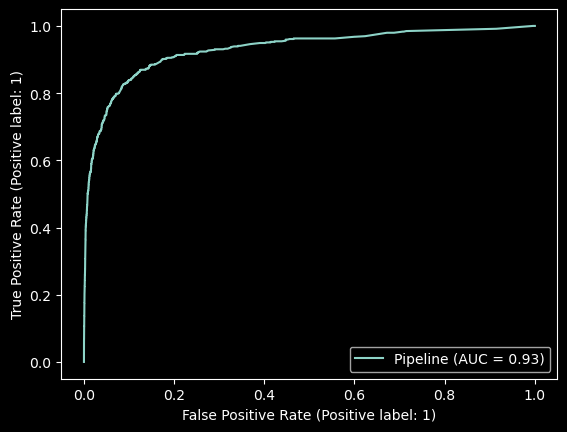

In [5]:
import wandb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_roc_curve

project_name = 'Decision Optimization Assignment'
# start a new run
run = wandb.init(project=project_name)

# predict labels for test set
test_predictions = modeling_pipeline.predict(test[predictive_features])
test_probabilities = modeling_pipeline.predict_proba(test[predictive_features])[:, 1]

# calculate metrics
conf_mat = confusion_matrix(test['Machine failure'], test_predictions)
accuracy = accuracy_score(test['Machine failure'], test_predictions)
precision = precision_score(test['Machine failure'], test_predictions)
recall = recall_score(test['Machine failure'], test_predictions)
f1 = f1_score(test['Machine failure'], test_predictions)
roc_auc = roc_auc_score(test['Machine failure'], test_probabilities)

# calculate feature importance for tree-based model
feature_importance = modeling_pipeline.named_steps['classifier'].feature_importances_

# log metrics to wandb
wandb.log({"confusion_matrix": wandb.plots.HeatMap(
    np.unique(test['Machine failure']), 
    np.unique(test['Machine failure']), 
    conf_mat, 
    show_text=True
)})
wandb.log({"accuracy": accuracy})
wandb.log({"precision": precision})
wandb.log({"recall": recall})
wandb.log({"f1": f1})
wandb.log({"roc_auc": roc_auc})
wandb.log({"feature_importance": wandb.Histogram(feature_importance)})

# plot roc curve
ax = plot_roc_curve(modeling_pipeline, test[predictive_features], test['Machine failure'])
ax.figure_.savefig("roc_curve.png")
wandb.log({"roc_curve": wandb.Image("roc_curve.png")})

# end run
run.finish()


# Simulation

Your model will predict the likelihood of failure for each row in the data. You will then apply a decision function that considers `Machine Type`` and the probability of failure to decide whether to do preventive maintenance for that machine at that time.

If choose to do preventive maintenance, you pay the cost shown below for `Cost of preventive maintenance` for that machine type. If you don't do maintenance and the observed data in validation is that it failed, then you pay `Cost of failure` for that machine type.

| Machine Type | Cost of preventive maintenance | Cost of failure if you don't do preventive maintenance |
|--------------|--------------------------------|--------------------------------------------------------|
| L            | 1000                           | 30000                                                  |
| M            | 5000                           | 250000                                                 |
| H            | 10000                          | 800000                                                 |

First, write a function that determines the costs given some data, a machine learning model to predict failure rates, and a decision function:

In [12]:
def log_metrics(outcomes, decision_function, tags = None):
    with wandb.init(project=project_name,
                    name=decision_function.__name__,
                    job_type="repair decision cost simulations",
                    tags= tags):
        wandb.log({
            "repair_costs_type_L": outcomes[outcomes["Type"] == "L"]["repair_cost"].sum(),
            "repair_costs_type_M": outcomes[outcomes["Type"] == "M"]["repair_cost"].sum(),
            "repair_costs_type_H": outcomes[outcomes["Type"] == "H"]["repair_cost"].sum(),
            
            "failure_costs_type_L": outcomes[outcomes["Type"] == "L"]["failure_cost"].sum(),
            "failure_costs_type_M": outcomes[outcomes["Type"] == "M"]["failure_cost"].sum(),
            "failure_costs_type_H": outcomes[outcomes["Type"] == "H"]["failure_cost"].sum(),
            
            "total_costs_type_L": outcomes[outcomes["Type"] == "L"]["failure_cost"].sum() + outcomes[outcomes["Type"] == "L"]["repair_cost"].sum(),
            "total_costs_type_M": outcomes[outcomes["Type"] == "M"]["failure_cost"].sum() + outcomes[outcomes["Type"] == "M"]["repair_cost"].sum(),
            "total_costs_type_H": outcomes[outcomes["Type"] == "H"]["failure_cost"].sum() + outcomes[outcomes["Type"] == "H"]["repair_cost"].sum(),
            
            "repair_costs": outcomes["repair_cost"].sum(),
            "failure_costs": outcomes["failure_cost"].sum(),
            "total_costs": outcomes["repair_cost"].sum() + outcomes["failure_cost"].sum(),
        })
    return

In [13]:
def cost_calculator(data, model, decision_function, tags=None, log=True):
    """
    Args:
        data (pandas.DataFrame): The dataset on which the cost is calculated.
        model (sklearn-compatible model. Compatible with type sklearn.base.BaseEstimator): The predictive model.
        decision_function (function): The decision function of the model.
    
    Returns:
        int: The cost of using this decision function with the predictive model on this dataset.
    """
    data = data.copy()
    
    repair_cost_df = pd.DataFrame(
        {
            'machine_type': ['L', 'M', 'H'],
            'maintenance_cost': [1000, 5000, 10000],
            'failure_cost': [30000, 250000, 800000]
        }
    )
    
    data = data.merge(repair_cost_df, how='left', left_on='Type', right_on='machine_type', validate='many_to_one').drop('machine_type', axis=1)
    
    data['repair_decision'] = decision_function(data, model)
    
    data["repair_cost"] = np.where(
        data["repair_decision"] == 1,
        data["repair_decision"] * data["maintenance_cost"],
        0
    )
    
    data["failure_cost"] = np.where(
        (data["repair_decision"] == 0) & (data["Machine failure"] == 1),
        data["failure_cost"],
        0
    )
    
    if log:
        log_metrics(data, decision_function, tags)
    
    return data

# first_costs = cost_calculator(test, modeling_pipeline, first_decision_function, tags=['test_data'], log=True)

Here is an example decision function.

In [14]:
def first_decision_function(data, model):
    """
    Args:
        data (pandas.DataFrame): Data to make a decision on
        model (sklearn model): A trained sklearn classifier
    
    Returns:
        repair_decision (bool): A decision to repair or not to repair
    """
    fixed_decision_threshold = 0.01
    probability_of_failure = model.predict_proba(data[predictive_features])[:, 1]
    repair_decision = probability_of_failure > fixed_decision_threshold
    return repair_decision

first_costs = cost_calculator(test, modeling_pipeline, first_decision_function)

first_costs
# Log this with wandb. Then add and test two more decision functions.
# You should be able to find a better decision function than the first one.
# Do you see how to do better than just changing `fixed_decision_threshold` to a different number?

failure_costs,▁
failure_costs_type_H,▁
failure_costs_type_L,▁
failure_costs_type_M,▁
repair_costs,▁
repair_costs_type_H,▁
repair_costs_type_L,▁
repair_costs_type_M,▁
total_costs,▁
total_costs_type_H,▁
total_costs_type_L,▁


,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,maintenance_cost,failure_cost,repair_decision,repair_cost
0,100000,H32366,H,300.7,309.5,1715,30.5,29,0,0,0,0,0,0,10000,0,False,0
1,100001,L53583,L,300.1,309.8,1649,34.6,129,0,0,0,0,0,0,1000,0,False,0
2,100002,L48797,L,297.8,307.8,1563,34.3,59,0,0,0,0,0,0,1000,0,False,0
3,100003,L56170,L,297.1,307.9,1418,49.3,146,0,0,0,0,0,0,1000,0,False,0
4,100004,L55282,L,300.3,311.8,1413,41.5,182,0,0,0,0,0,0,1000,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0,5000,0,True,5000
36425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0,10000,0,False,0
36426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0,1000,0,True,1000
36427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0,1000,0,False,0


In [40]:
def second_decision_function(data, model):
    """
    Args:
        data (pandas.DataFrame): Data to make a decision on
        model (sklearn model): A trained sklearn classifier
    
    Returns:
        repair_decision (bool): A decision to repair or not to repair
    """
    machine_types = ['L', 'M', 'H']
    decision_thresholds = [0.02, 0.004, 0.006] 
    repair_decisions = []
    original_indices = []
    
    for machine_type, decision_threshold in zip(machine_types, decision_thresholds):
        data_by_type = data[data.Type == machine_type]
        probability_of_failure = model.predict_proba(data_by_type[predictive_features])[:, 1]
        repair_decision = probability_of_failure > decision_threshold
        repair_decisions.extend(repair_decision)
        original_indices.extend(data_by_type.index)
    
    repair_decision_df = pd.DataFrame({'index': original_indices, 'repair_decision': repair_decisions})
    repair_decision_df = repair_decision_df.sort_values(by='index')
    
    return np.array(repair_decision_df['repair_decision'])

second_costs = cost_calculator(test, modeling_pipeline, second_decision_function)

second_costs

failure_costs,▁
failure_costs_type_H,▁
failure_costs_type_L,▁
failure_costs_type_M,▁
repair_costs,▁
repair_costs_type_H,▁
repair_costs_type_L,▁
repair_costs_type_M,▁
total_costs,▁
total_costs_type_H,▁
total_costs_type_L,▁


,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,maintenance_cost,failure_cost,repair_decision,repair_cost
0,100000,H32366,H,300.7,309.5,1715,30.5,29,0,0,0,0,0,0,10000,0,False,0
1,100001,L53583,L,300.1,309.8,1649,34.6,129,0,0,0,0,0,0,1000,0,False,0
2,100002,L48797,L,297.8,307.8,1563,34.3,59,0,0,0,0,0,0,1000,0,False,0
3,100003,L56170,L,297.1,307.9,1418,49.3,146,0,0,0,0,0,0,1000,0,False,0
4,100004,L55282,L,300.3,311.8,1413,41.5,182,0,0,0,0,0,0,1000,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0,5000,0,True,5000
36425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0,10000,0,False,0
36426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0,1000,0,True,1000
36427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0,1000,0,False,0


Once you have created and compared at least three decision functions, you can create and submit your report comparing them. Remember to describe (in a sentence or two) your plan for dealing with the covariate shift and testing issues described at the top of this assignment.

Good Luck!